# Ejercicio 1: Predicción de precios de automóviles

#### Elaborado por: Dalia Yvette Domínguez Jiménez

Para correr este notebook, se necesita el archivo 'DataFloat.csv', el cual contiene los datos limpios y con las imputaciones necesarias, que se realizaron en el notebook 'Tarea2Ejercicio1Preprocesamiento'.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from itertools import combinations
from sklearn import linear_model

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from scipy import stats

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error#, r2_score

pd.set_option('display.max_rows', None, 'display.max_columns', None)

## Conjunto de datos


In [2]:
df = pd.read_csv('DataFloat.csv')
df = df.drop(columns='Unnamed: 0')
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3.0,161.0,alfa-romero,gas,std,2.0,convertible,rwd,front,88.6,168.8,64.1,48.8,2548.0,dohc,4.0,130.0,mpfi,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,13495.0
1,3.0,161.0,alfa-romero,gas,std,2.0,convertible,rwd,front,88.6,168.8,64.1,48.8,2548.0,dohc,4.0,130.0,mpfi,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,16500.0
2,1.0,161.0,alfa-romero,gas,std,2.0,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823.0,ohcv,6.0,152.0,mpfi,2.68,3.47,9.0,154.0,5000.0,19.0,26.0,16500.0
3,2.0,164.0,audi,gas,std,4.0,sedan,fwd,front,99.8,176.6,66.2,54.3,2337.0,ohc,4.0,109.0,mpfi,3.19,3.40,10.0,102.0,5500.0,24.0,30.0,13950.0
4,2.0,164.0,audi,gas,std,4.0,sedan,4wd,front,99.4,176.6,66.4,54.3,2824.0,ohc,5.0,136.0,mpfi,3.19,3.40,8.0,115.0,5500.0,18.0,22.0,17450.0


Separar los datos en un data frame con variables numéricas

In [3]:
df_num = df.select_dtypes(include=[np.float64])
df_num.head()

,symboling,normalized-losses,num-of-doors,wheel-base,length,width,height,curb-weight,num-of-cylinders,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3.0,161.0,2.0,88.6,168.8,64.1,48.8,2548.0,4.0,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,13495.0
1,3.0,161.0,2.0,88.6,168.8,64.1,48.8,2548.0,4.0,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,16500.0
2,1.0,161.0,2.0,94.5,171.2,65.5,52.4,2823.0,6.0,152.0,2.68,3.47,9.0,154.0,5000.0,19.0,26.0,16500.0
3,2.0,164.0,4.0,99.8,176.6,66.2,54.3,2337.0,4.0,109.0,3.19,3.40,10.0,102.0,5500.0,24.0,30.0,13950.0
4,2.0,164.0,4.0,99.4,176.6,66.4,54.3,2824.0,5.0,136.0,3.19,3.40,8.0,115.0,5500.0,18.0,22.0,17450.0


Data frame para variables categóricas

In [4]:
df_cat = df.select_dtypes(exclude=[np.number])
df_cat=df_cat[['fuel-type','aspiration','drive-wheels','engine-location']]
df_cat.head()

,fuel-type,aspiration,drive-wheels,engine-location
0,gas,std,rwd,front
1,gas,std,rwd,front
2,gas,std,rwd,front
3,gas,std,fwd,front
4,gas,std,4wd,front


Obtener variables dummies de el data frame de variables categóricas

Hacemos un arreglo para las variables continuas y otro para el precio

In [5]:
var_num = df_num[df_num.columns[:-1]].to_numpy()
df_dumm=df.select_dtypes(exclude=["number","bool_","object_"])
var_dum = df_dumm.to_numpy()
precio = df_num[['price']].to_numpy()

In [6]:
data = np.concatenate((var_num,var_dum),axis=1)
data.shape

(201, 17)

Dividimos el conjunto de datos en entrenamiento ($80\%)$ y prueba ($20\%)$. La partición de entrenamiento se utilizará para entrenar y evaluar los modelos por validación cruzada con repteción.

In [7]:
X_ent, X_pru, y_ent, y_pru = train_test_split(data,precio,train_size=0.80, random_state=0)
X_ent.shape

(160, 17)

## Definimos la validación cruzada con repetición

Utilizamos la validación cruzada con 5 particiones y 10 repeticiones que se definió en clase. La cual nos regresa el número de repetición ($i$), el número de partición ($j$), el número de evaluación ($i * k + j$) y los arreclos de entrenamiento y validación de los atributos y la variable objetivo.

In [8]:
def vcrep_kpart(X, y, r=10, k=5):
    n = X.shape[0]
    t_pliegue = int(n / k)
    for i in range(r):
        perm = np.random.permutation(n)
        X = X[perm]
        y = y[perm]
        for j in range(k):
            masc_val = np.zeros(n, dtype=bool)
            masc_val[t_pliegue*j:t_pliegue*(j+1)] = True
            masc_ent = np.logical_not(masc_val)
            X_ent = X[masc_ent]
            y_ent = y[masc_ent]
            X_val = X[masc_val]
            y_val = y[masc_val]
      
            yield i, j, i * k + j, X_ent, y_ent, X_val, y_val

## Expansión polinomial

Vamos a definir una función para la exponsión polinomial de un vector con 1 o más atributos (definido en clase). Esta expansión polinomial no considera las interaciones, por ejemplo, la expansión polinomial de grado 2 de un vector $\mathbf{x}_i$ con 4 atributos $x$ es:

$$  \phi(\mathbf{x}) = 1+ x_0 + x_1 +x_2 + x_3 + x_0^2 + x_1^2 +x_2^2 + x_3^2 $$

In [9]:
def expol(X, grado):
    phi_X = X
    for i in range(grado - 1):
        powerX = np.power(X, i + 2)
        phi_X = np.column_stack((phi_X, powerX))
    
    unos = np.ones(phi_X.shape[0])
    return np.column_stack((unos, phi_X))

También compararemos con la expansión polinomial de sklearn, la cual sí contiene las interacciones, por ejemplo, para el mismo caso anterior tenemos la siguiente expansión polinomial:

$$  \phi(\mathbf{x}) = 1 + x_0 + x_1 +x_2 + x_3 + x_0^2 + x_0x_1 + x_0x_2 + x_0x_3  + x_1^2 + x_1x_2 + x_1x_3 + x_3^2 + x_2x_3$$

In [10]:
poly = PolynomialFeatures(degree=2,interaction_only=True)

## Regresión lineal polinomial

La regresión lineal de sklearn es un modelo lineal que utiliza minimos cuadrados para calcular el vector de coeficientes $\mathbf{\omega}$ que mejor predice el valor de nuestra variable objetivo (precio):

$$ f(\mathbf{x}) = \mathbf{\omega} \phi(\mathbf{x}) $$

colocando $\phi(\mathbf{x})$ como un vector, cada sumando es una entrada.

Definimos una función para evaluar un modelo por validación cruzada repetida, nos devuelve el error cuadrático medio del conjunto de entrenamiento y de validación 

In [11]:
def ent_eval(m,X_ent,y_ent,grados,inter=True):
    
    mse_ent = np.zeros([50,len(grados)])
    mse_val = np.zeros([50,len(grados)])
    
    for i,g in enumerate(grados):
        for j, k, l, X_ent_vc, y_ent_vc, X_val_vc, y_val_vc in vcrep_kpart(X_ent, y_ent):
            
            if inter:
                poly = PolynomialFeatures(degree=g,interaction_only=True)
                X_ent_poly = poly.fit_transform(X_ent_vc)
                X_val_poly = poly.fit_transform(X_val_vc)
            else:
                X_ent_poly = expol(X_ent_vc,g)
                X_val_poly = expol(X_val_vc,g)

            m.fit(X_ent_poly, y_ent_vc)  

            y_ent_pred = m.predict(X_ent_poly)
            y_val_pred = m.predict(X_val_poly)

            mse_ent[l,i]=mean_squared_error(y_ent_vc, y_ent_pred)
            mse_val[l,i]=mean_squared_error(y_val_vc, y_val_pred)
    
    return mse_ent, mse_val

## a. Mínimos cuadrados con expansión polinomial de diferentes grados

### a.1 Regresión polinomial con interacciones

Evaluamos el modelo con diferentes grados: 1, 2 y 3 con todos los atributos

In [12]:
grados = [1,2,3]
mse_ent_int,mse_val_int=ent_eval(LinearRegression(),X_ent,y_ent,grados)

Graficamos el promedio de los errores cuadráticos médicos de cada grado del la regresión lineal polinomial, tanto de entrenamiento como de validación.

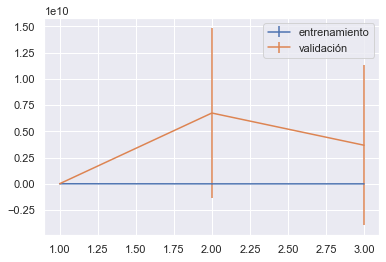

In [13]:
plt.errorbar(grados,mse_ent_int.mean(axis=0),mse_ent_int.std(axis=0),label='entrenamiento')
plt.errorbar(grados,mse_val_int.mean(axis=0),mse_val_int.std(axis=0),label='validación')
plt.legend()
plt.show()

### a.2 Regresión lineal polinomial sin interacciones

Utilizando regresión linean sin interacción obtenemos urrores cuadraticos medios mucho menores que con interacciones. Por lo que en los siguientes modelos utilizaremos esta expansión polinomial. Además, el tiempo de ejecución es más rápido.

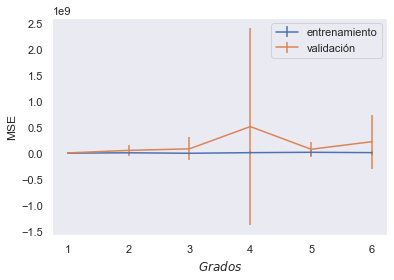

In [14]:
grados = [1,2,3,4,5,6]
mse_ent,mse_val=ent_eval(LinearRegression(),X_ent,y_ent,grados,inter=False)
plt.errorbar(grados,mse_ent.mean(axis=0),mse_ent.std(axis=0),label='entrenamiento')
plt.errorbar(grados,mse_val.mean(axis=0),mse_val.std(axis=0),label='validación')
plt.xlabel('$Grados$')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()

Se visualiza un sobreajuste incluso desde el polinomio de grado 2.

## b. Mínimos cuadrados con expansión polinomial de grado 20 

### b.1 Penalización $\ell_1$ y diferentes $\lambda$

Si penalizamos los parámetros por norma $\ell_1$ obtenemos LASSO (_least absolute shrinkage and selection operator_). Probemos con LASSO usando diferentes valores de $\lambda$

In [15]:
def ent_ev_lambdasLasso(lambdas,X_ent,y_ent):
                        
    mse_ent = np.zeros([50,lambdas.shape[0]])
    mse_val = np.zeros([50,lambdas.shape[0]])
                        
    for i,l in enumerate(lambdas):    
        m = Lasso(alpha=l,tol=1)

        mseEnt,mseVal=ent_eval(m,X_ent,y_ent,[20],inter=False)

        mse_ent[:,i] = mseEnt.reshape(50)
        mse_val[:,i] = mseVal.reshape(50)
    
    return mse_ent, mse_val

Intentamos con un rango de lambdas de $1\times10^{-20}$ a $1\times10^{20}$ 

In [16]:
lambdas = np.geomspace(1e-20, 1e20, num=20)
mse_ent, mse_val =ent_ev_lambdasLasso(lambdas,X_ent,y_ent)

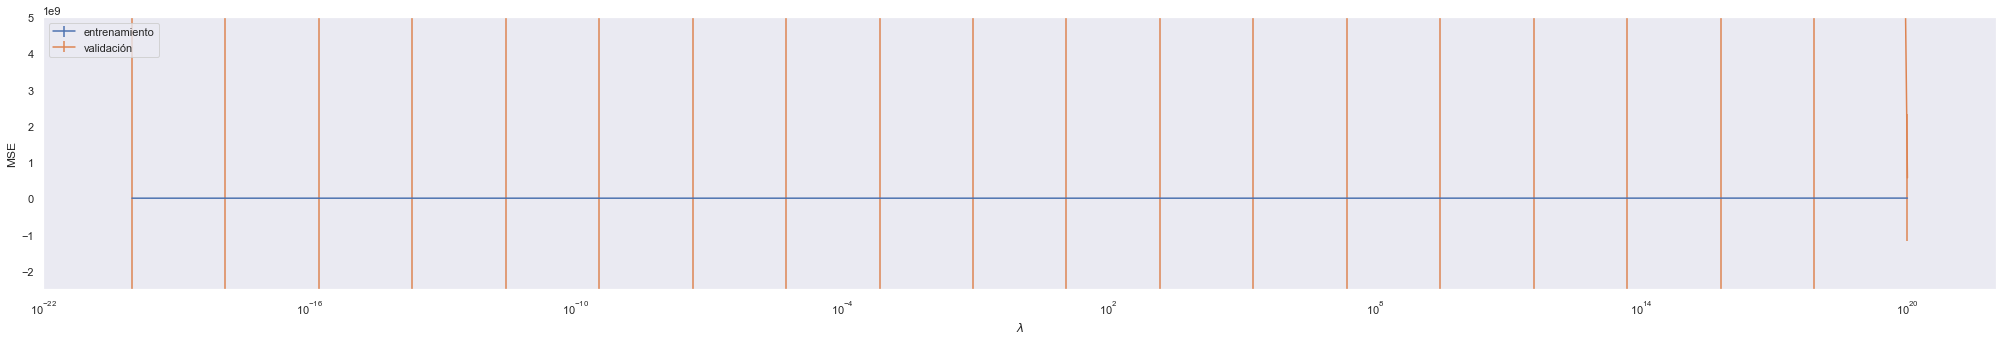

In [17]:
plt.figure(figsize=(35,5))
plt.errorbar(lambdas,mse_ent.mean(axis=0),mse_ent.std(axis=0),label='entrenamiento')
plt.errorbar(lambdas,mse_val.mean(axis=0),mse_val.std(axis=0),label='validación')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('MSE')
plt.ylim([-0.25e10,5e9])
plt.legend()
plt.grid()
plt.show()

Observamos que el modelo no se sobreajusta inmediatamente.

## b.2 Penalización por norma $\ell_2$
Se puede ver que después del grado 2 los modelos se sobreajustan. Probemos entrenar un modelo de regresión lineal con penalización por norma $\ell_2$. La solución cerrada está dada por  
$$
\boldsymbol{\theta}_{MAP} = (\lambda \mathbf{I} + \mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}
$$

Generamos una nueva clase hija de `RegresionLineal` donde se define el método (`_estima_parametros`) con esta solución.

Estas son clases y funciones utilizadas en clase.


In [18]:
class MinimosCuadradosL2( ):
    def __init__(self, lc = 0.01):
        self._lc = lc

    def _estima_parametros(self, X, y):
        lcI = self._lc * np.identity(X.shape[1])
        self.parameters = np.linalg.inv(lcI + X.T @ X) @ X.T @ y

    def fit(self, X, y):
        '''
        Estima los parámetros del modelo
        '''
        self._estima_parametros(X, y)
        
    def predict(self, X):
        '''
        Predice valores de vectores dados
        '''
        return X @ self.parameters

In [19]:
def ent_ev_lambdasL2(lambdas,X_ent,y_ent):
                        
    mse_ent = np.zeros([50,lambdas.shape[0]])
    mse_val = np.zeros([50,lambdas.shape[0]])
                        
    for i,l in enumerate(lambdas):    
        m = MinimosCuadradosL2(lc=l)
        
        mseEnt,mseVal=ent_eval(m,X_ent,y_ent,[20],inter=False)
        mse_ent[:,i] = mseEnt.reshape(50)
        mse_val[:,i] = mseVal.reshape(50)
    
    return mse_ent, mse_val

Intentamos con un rango de lambdas de $1\times10^{-20}$ a $1\times10$ 

In [20]:
lambdas = np.geomspace(1e-20, 10, num=20)
mse_ent, mse_val =ent_ev_lambdasL2(lambdas,X_ent[:,:16],y_ent)

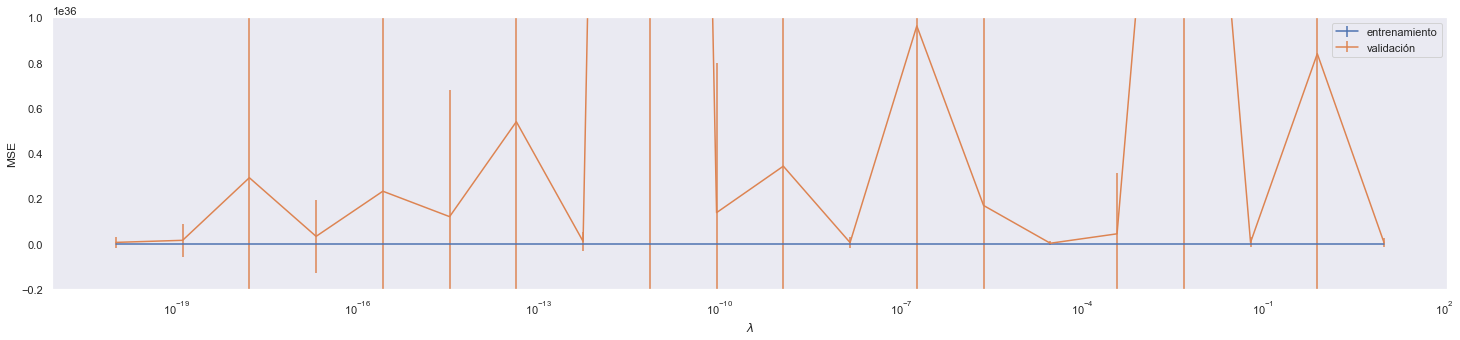

In [21]:
plt.figure(figsize=(25,5))
plt.errorbar(lambdas,mse_ent.mean(axis=0),mse_ent.std(axis=0),label='entrenamiento')
plt.errorbar(lambdas,mse_val.mean(axis=0),mse_val.std(axis=0),label='validación')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('MSE')
plt.ylim([-0.2e36,1e36])
plt.legend()
plt.grid()
plt.show()

## C. Mínimos cuadrados con expansión polinomial de grado 2 y selección de atributos.

Se utiliza una estrategía de extracción de características basada en filtros.
Es común utilizar medidas estadísticas de correlación entre las variables de entrada y de salida.

Las medidas estadisticas usadas son generalmente calculadas con una variable de entrada a la vez junto que la variable objetivo. Por esta razón, son llamados como medidas estadísticas univariables. Lo que significa que no hay interacciones entre variables de entrada. 

La elección de mediciónes estadísitcas depende de la naturaleza de los datos de entrada y de salida. En este caso de regresión, tenemos variables numéricas y catergórica, por lo que emplearemos el coeficiente de correlación de Pearson para las variables numericas y coeficiente de correlación ANOVA para las variables categóricas.


### Correlación con variables continuas

Obtenemos la matriz de correlación

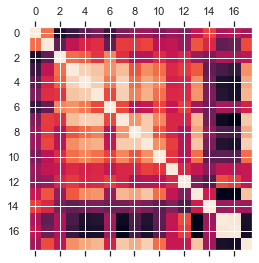

In [22]:
plt.matshow(df_num.corr(method='pearson'))
plt.show()

Observamos solo los valores de correlación con la variable precio

In [23]:
df_num.corr()['price']

symboling           -0.082391
normalized-losses    0.318956
num-of-doors         0.042435
wheel-base           0.584642
length               0.690628
width                0.751265
height               0.135486
curb-weight          0.834415
num-of-cylinders     0.708645
engine-size          0.872335
bore                 0.447934
stroke               0.073513
compression-ratio    0.071107
horsepower           0.810395
peak-rpm            -0.098308
city-mpg            -0.686571
highway-mpg         -0.704692
price                1.000000
Name: price, dtype: float64

Vamos a considerar aquellas variables con las que se obtiene un coeficiente de corelación de al menos 0.80:
1. curb-weight
2. engine-size
3. horsepower

Graficamos estas variables contra el precio

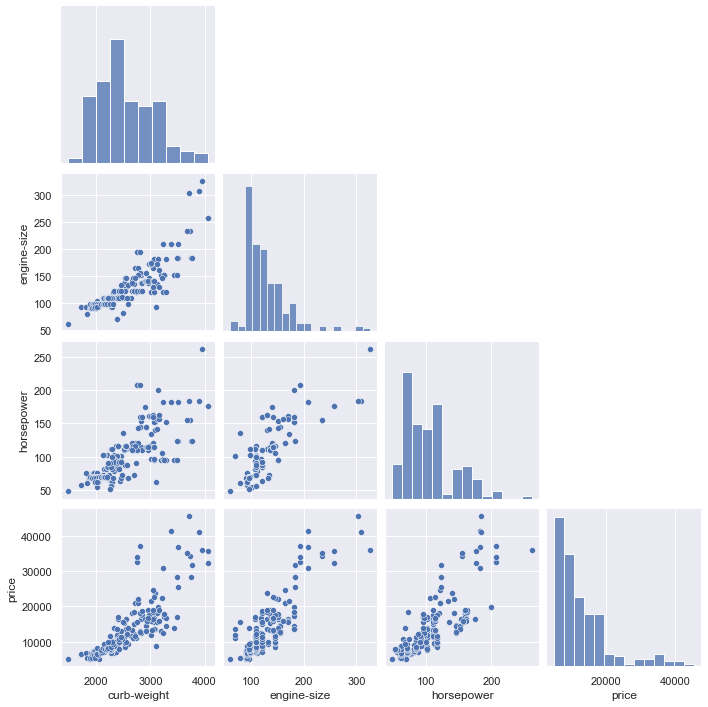

In [24]:
sns.pairplot(df[['curb-weight','engine-size','horsepower','price']],corner=True)
plt.show()

### ANOVA con variables categóricas

El análisis de varianza (ANOVA en inglés) es un método estadistico para evaluar si gay diferencias significativas entre las medias de dos o más grupos. El método de ANOVA calcula dos parámetros:

1. F-Test score: ANOVA asume que las medias de todos los grupos son los mismos, calcula cuánto se desvían las medias reales de la suposición y lo informan como el F-Test score. Una puntuación más amplia significa que hay una diferencia más grande entre los medios.

2. P-VALUE: El valor P dice cómo estadísticamente significativo es nuestro valor de puntuación calculada. Si nuestra variable de precio está fuertemente correlacionada con la variable que estamos analizando.

Para la selección de varaibles catergóricas consideraremos un F-Test score considerable y un valor P Pequeño.

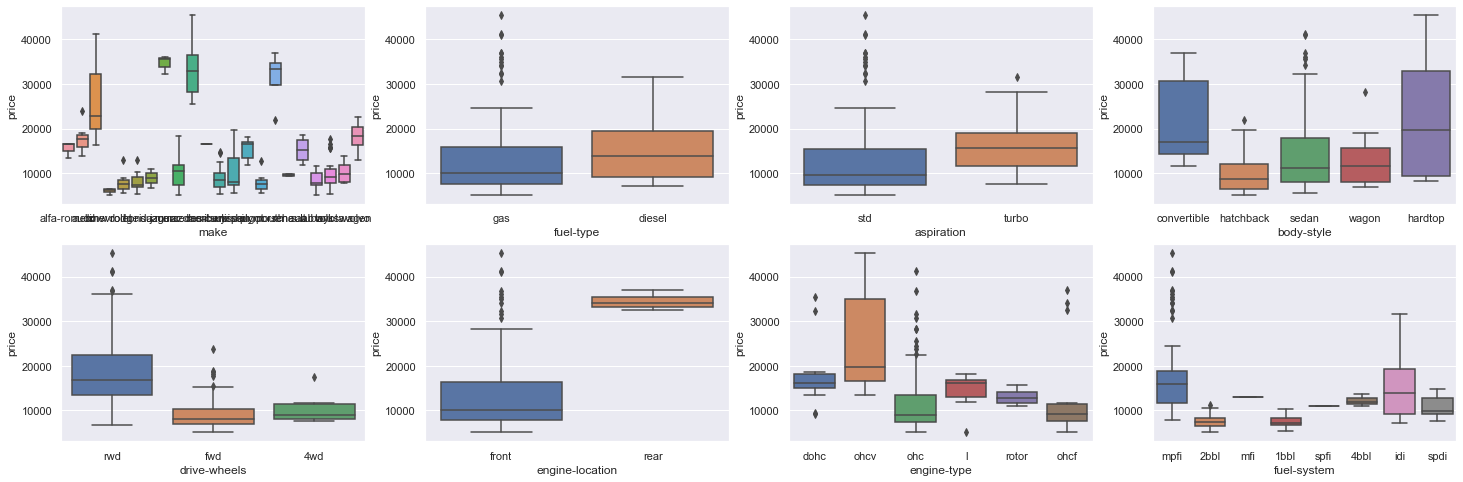

In [25]:
df_cat = df.select_dtypes(exclude=[np.number])
df_cat['price']=df['price']
fig, axes = plt.subplots(2, 4, figsize=(25, 8))
i = 0
for j,att in enumerate(df_cat.columns[:-1]):
    if j>3:
        j=j-4
        i=1
    sns.boxplot(ax=axes[i,j], x=att, y="price", data=df)

Realizamos un análisis rápido de varianzas entre clases de cada variable categórica:

In [26]:
def get_population(df,variable):
    df_var = pd.DataFrame()
    return [df[df[variable]==var]['price'] for var in df[variable].unique()]

In [27]:
for var in df_cat.columns[:-1]:
    f_val, p_val = stats.f_oneway(*get_population(df,var))  
    print(var)
    print( "ANOVA results: F=", f_val, ", P =", p_val)   

make
ANOVA results: F= 33.23210250666057 , P = 1.068342528777401e-50
fuel-type
ANOVA results: F= 2.4520196354787864 , P = 0.11896254438091516
aspiration
ANOVA results: F= 6.631286341771227 , P = 0.010745853841804088
body-style
ANOVA results: F= 9.12875185470821 , P = 8.779795237614595e-07
drive-wheels
ANOVA results: F= 67.95406500780398 , P = 3.3945443577151245e-23
engine-location
ANOVA results: F= 24.495550318865693 , P = 1.583490019777699e-06
engine-type
ANOVA results: F= 9.845110955850453 , P = 2.0865492749735665e-08
fuel-system
ANOVA results: F= 15.024444173557077 , P = 1.3142579909174807e-15


Les damos mayor consideración a aquellas variables con una F alta, pues queremos que los valores de las medias entre grupos sean diferentes para así considerar la variable categórica como una posible variable discriminante.

No consideramos: 'fuel-type', 'aspiration', 'body-style', 'engine-type' y 'fuel-type', pues tienen los valores F más bajos.
Consideramos:

Consideraremos: 'drive-wheels', y 'engine-location'.

No consideramos 'make' en este último grupo pues al tener muchas categorias, además de hacer el modelo más complejo, aumenta el hecho de que las medias no sean las mismas.

### Variables a considerar

* Númericas: 
1. Curb weight
2. Engine size
3. Horsepower

* Categóricas:
1. Drive wheels
2. Engine Locatinon

Preparamos los arreglos a utilizar

In [28]:
df_final = pd.get_dummies(df[['curb-weight','engine-size','horsepower','drive-wheels','engine-location','price']])
X=df_final.drop(['price'],axis=1).to_numpy()
y=df_final['price'].to_numpy()

In [29]:
print(X.shape,y.shape)

(201, 8) (201,)


Obtenemos una partición de entenamiento y/o validación y otra de prueba

In [30]:
X_ent, X_pru, y_ent, y_pru = train_test_split(X,y,train_size=0.80, random_state=0)

## Entranamiento y evaluación cruzada

Después de haber filtrado algunas variables, realizamos la validación cruzada con diferente combinación y número de atributos:

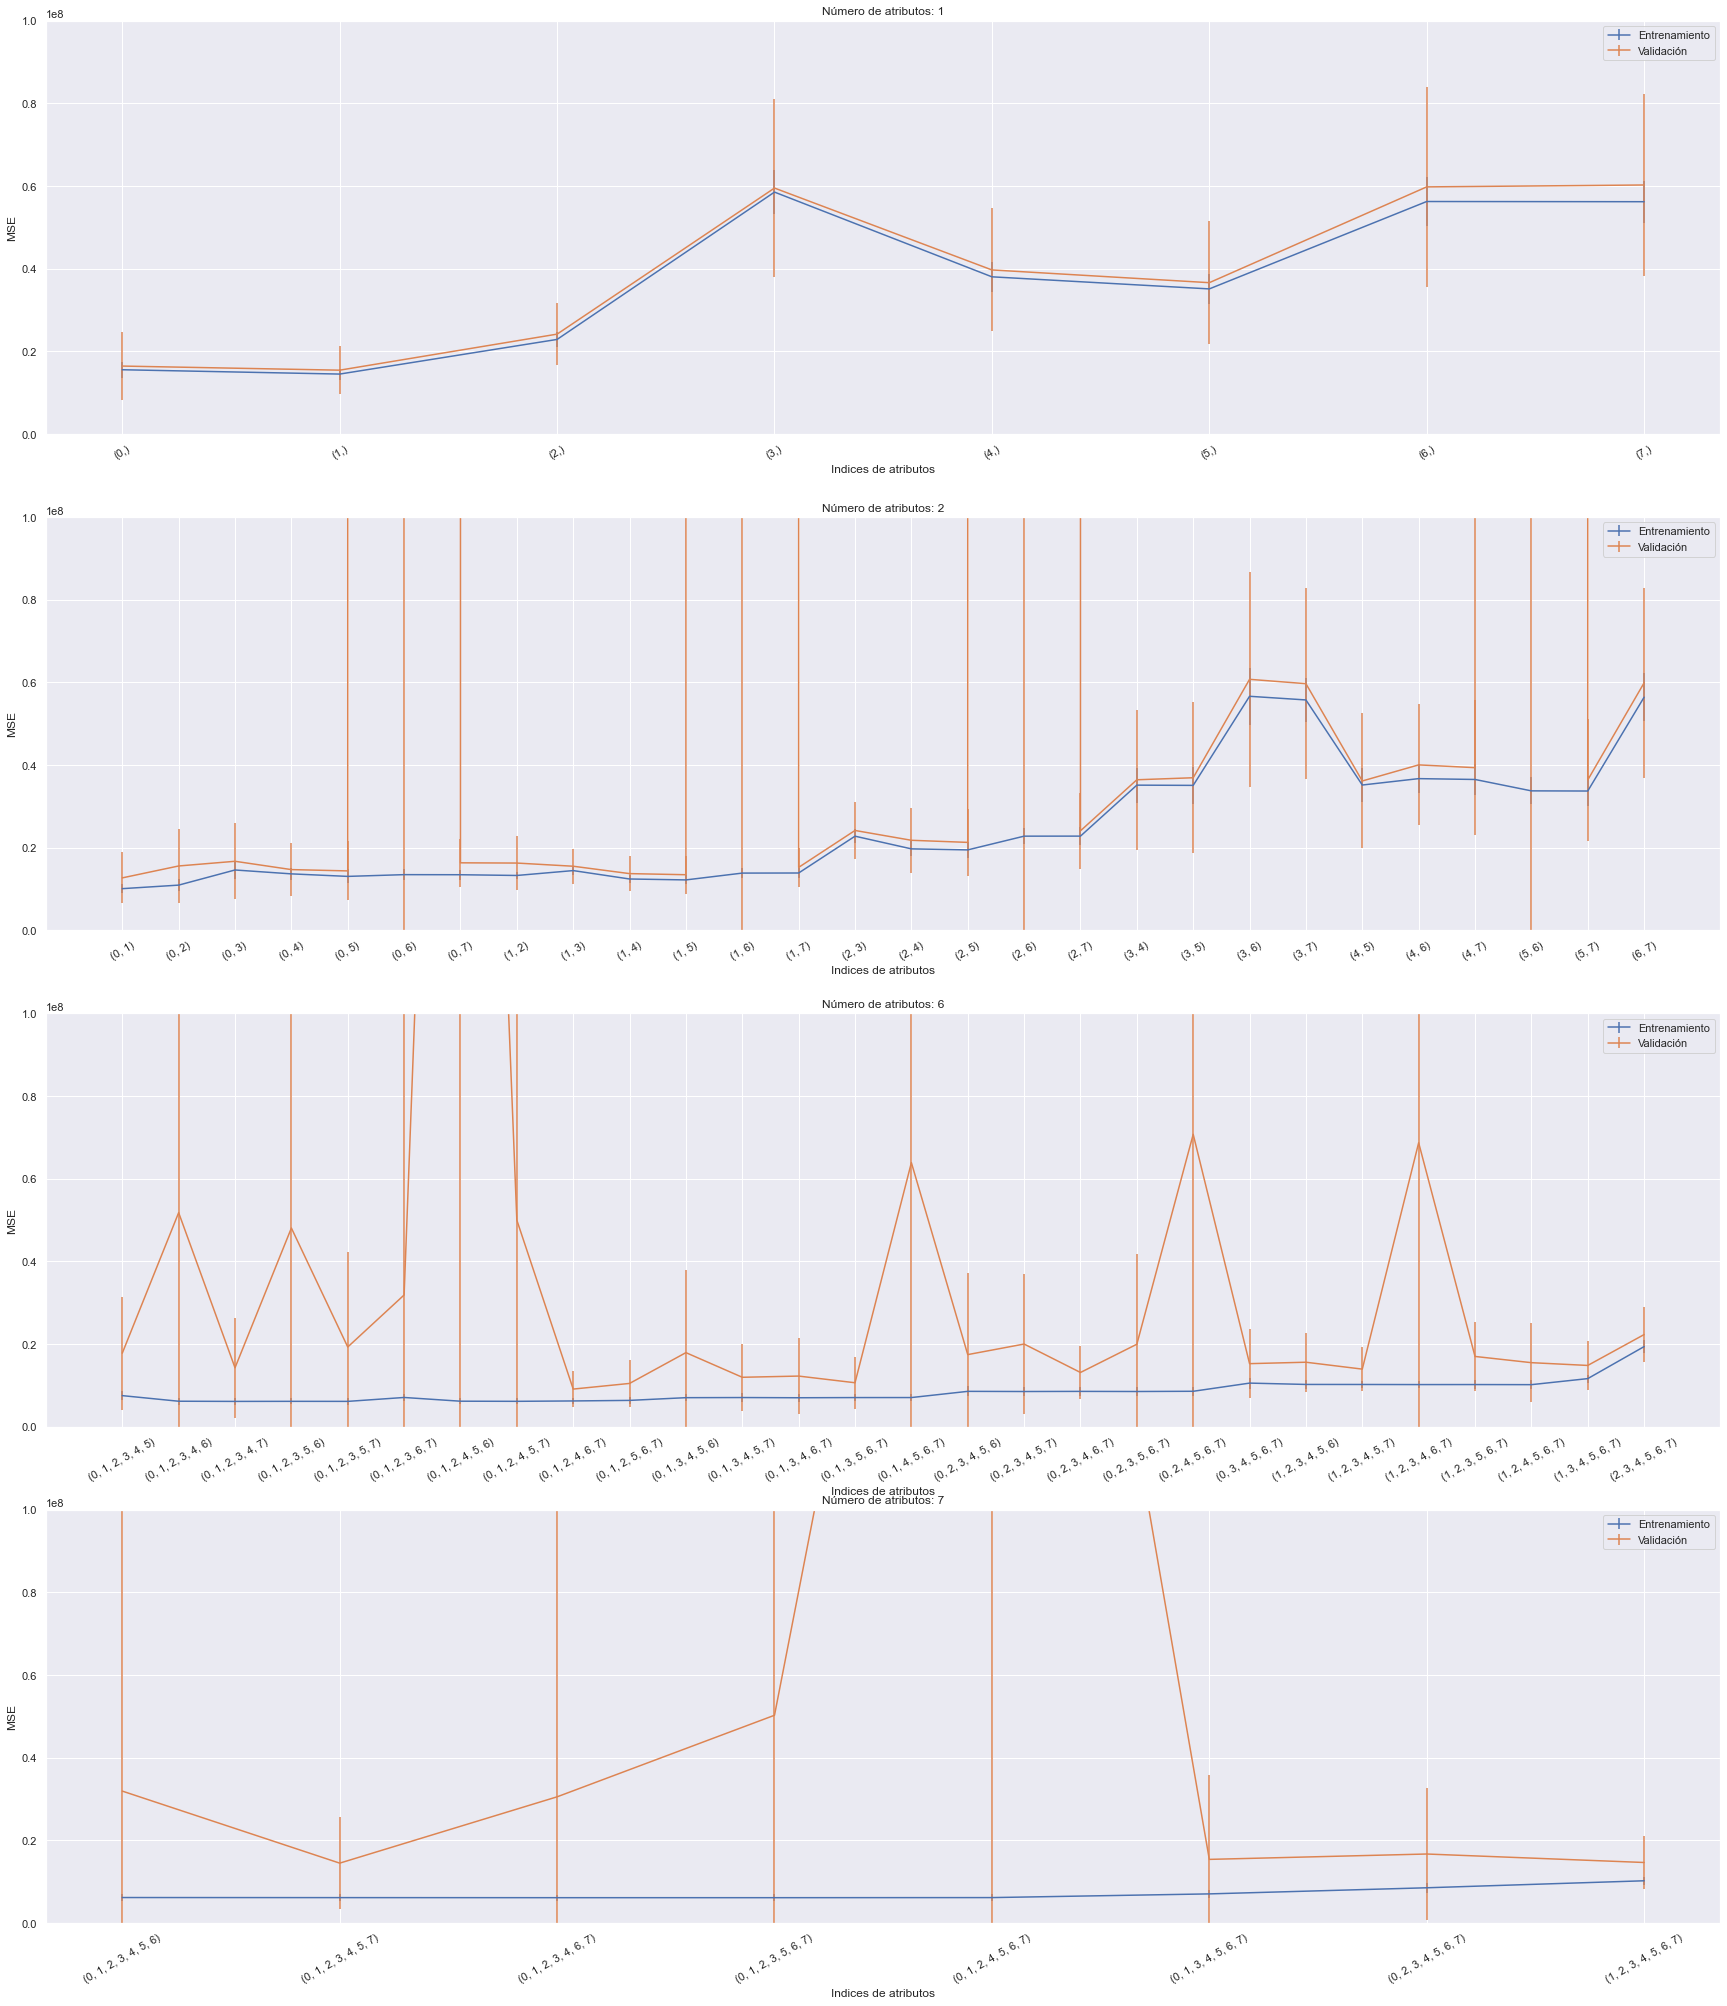

In [31]:
plt.figure(figsize=(30,35))

num_atributos = [1,2,6,7]

for num,num_var in enumerate(num_atributos):

    comb=list(combinations(range(8),num_var))
    mse_ent=np.zeros((50,len(comb),1))
    mse_val=np.zeros((50,len(comb),1))
    
    for i,c in enumerate(comb):
        mse_ent[:,i],mse_val[:,i] = ent_eval(LinearRegression(),X_ent[:,np.array(c)],y_ent,[2],inter=True)

    plt.subplot(len(num_atributos),1, num+1)
    plt.errorbar(range(len(comb)), mse_ent[:,:,0].mean(axis=0), yerr=mse_ent[:,:,0].std(axis=0))
    plt.errorbar(range(len(comb)), mse_val[:,:,0].mean(axis=0), yerr=mse_val[:,:,0].std(axis=0))
    plt.legend(['Entrenamiento','Validación'])
    plt.title('Número de atributos: '+str(num_var))
    plt.xlabel('Indices de atributos')
    plt.ylabel('MSE')
    plt.xticks(range(len(comb)), [str(i) for i in comb], rotation=30) 
    plt.ylim([0,1e8])

Seleccionamos aquella combinación de atributos con menor error 

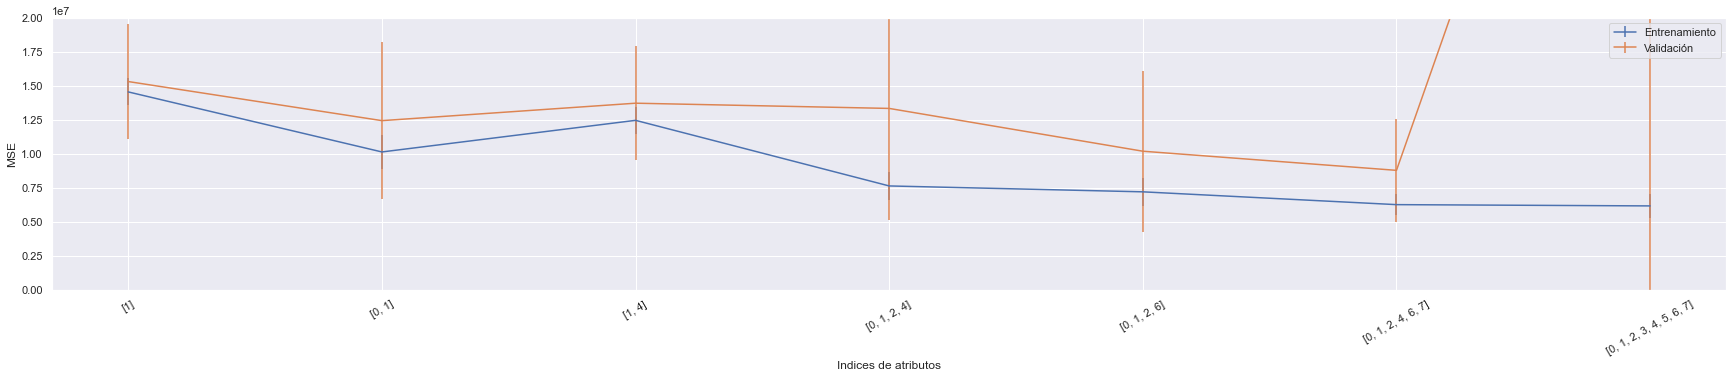

In [32]:
plt.figure(figsize=(30,5))

comb=[[1],[0,1],[1,4],[0,1,2,4],[0,1,2,6],[0,1,2,4,6,7],[0,1,2,3,4,5,6,7]]

# num_atributos = [1,2,4,6,7]
mse_ent=np.zeros((50,len(comb),1))
mse_val=np.zeros((50,len(comb),1))

for i, var in enumerate( comb ):
  
    mse_ent[:,i],mse_val[:,i] = ent_eval(LinearRegression(),X_ent[:,np.array(var)],y_ent,[2],inter=True)

plt.errorbar(range(len(comb)), mse_ent[:,:,0].mean(axis=0), yerr=mse_ent[:,:,0].std(axis=0))
plt.errorbar(range(len(comb)), mse_val[:,:,0].mean(axis=0), yerr=mse_val[:,:,0].std(axis=0))
plt.legend(['Entrenamiento','Validación'])
plt.xlabel('Indices de atributos')
plt.ylabel('MSE')
plt.xticks(range(len(comb)), [str(i) for i in comb], rotation=30) 
plt.ylim([0,2e7])
plt.show()

Los atributos con los que se obtienen menor error son:

In [33]:
att=np.array([0,1,2,4,6,7])
df_final.columns[np.array([0,1,2,4,6,7])]

Index(['curb-weight', 'engine-size', 'horsepower', 'drive-wheels_4wd',
       'drive-wheels_rwd', 'engine-location_front'],
      dtype='object')

### Gráficas de predicciones

In [34]:
X_ent1, X_val, y_ent1, y_val = train_test_split(X_ent,y_ent,train_size=0.80, random_state=0)

Primero para el modelo polinomial con interacciones:

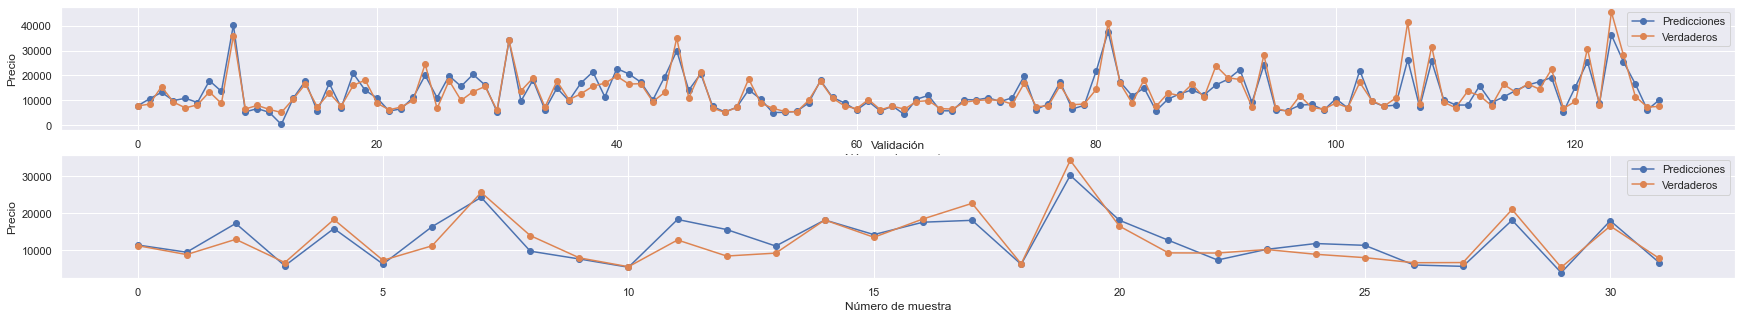

In [35]:
plt.figure(figsize=(30,5))
polInt2=LinearRegression()
poly = PolynomialFeatures(degree=2,interaction_only=True)
polInt2.fit(X_ent1[:,np.array([0,1,2,4,6,7])],y_ent1)
phi=poly.fit_transform(X_ent1[:,np.array([0,1,2,4,6,7])])


plt.subplot(2,1,1)
plt.plot(polInt2.predict(X_ent1[:,np.array([0,1,2,4,6,7])]),'-o')
plt.plot(y_ent1,'-o')
plt.xlabel('Número de muestra')
plt.ylabel('Precio')
plt.legend(['Predicciones','Verdaderos'])

plt.subplot(2,1,2)
plt.plot(polInt2.predict(X_val[:,np.array([0,1,2,4,6,7])]),'-o')
plt.plot(y_val,'-o')
plt.title('Validación')
plt.xlabel('Número de muestra')
plt.ylabel('Precio')
plt.legend(['Predicciones','Verdaderos'])

## Elección del modelo

### Entrenar el modelo

Elegimos un polinomio de grado 2 con interacciones, penalización por norma $l_1$ y selección de atributos.

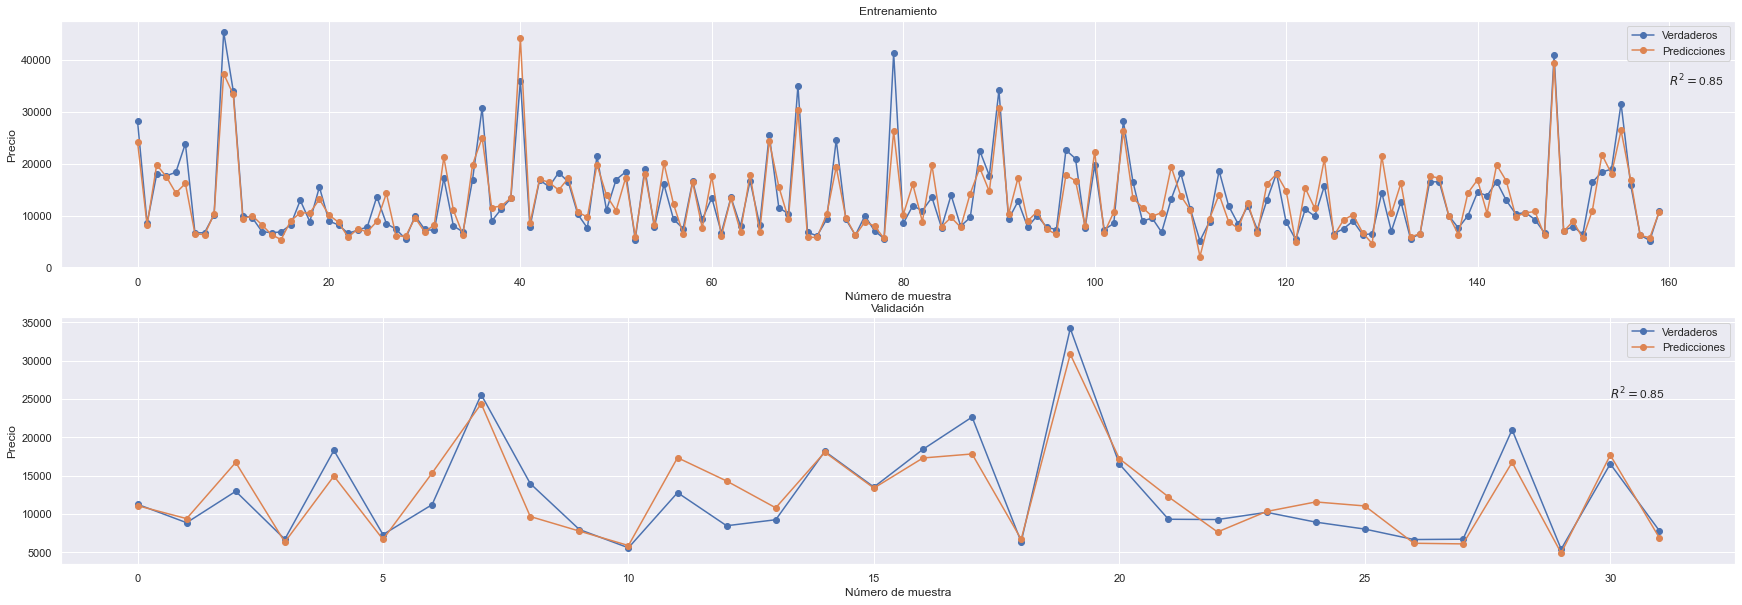

In [36]:
m = Lasso(alpha=1e4,tol=0.08)
X1 = X_ent[:,np.array([0,1,2,4,6,7])]
X2 = X_val[:,np.array([0,1,2,4,6,7])]

poly = PolynomialFeatures(degree=2,interaction_only=True)
phi_ent = poly.fit_transform(X1)
m.fit(phi_ent,y_ent)

plt.figure(figsize=(30,10))

plt.subplot(2,1,1)
plt.plot(y_ent,'-o')
m.predict(phi_ent)
plt.plot(m.predict(phi_ent),'-o')
plt.text(160,35000,'$R^2=${r2:.2f}'.format(r2=m.score(phi_ent,y_ent)))
plt.title('Entrenamiento')
plt.xlabel('Número de muestra')
plt.ylabel('Precio')
plt.legend(['Verdaderos','Predicciones'])

plt.subplot(2,1,2)
plt.plot(y_val,'-o')
phi_val = poly.fit_transform(X2)
plt.plot( m.predict(phi_val),'-o')
plt.text(30,25000,'$R^2=${r2:.2f}'.format(r2=m.score(phi_val,y_val)))
plt.title('Validación')
plt.xlabel('Número de muestra')
plt.ylabel('Precio')
plt.legend(['Verdaderos','Predicciones'])

plt.show()

### Probar el modelo

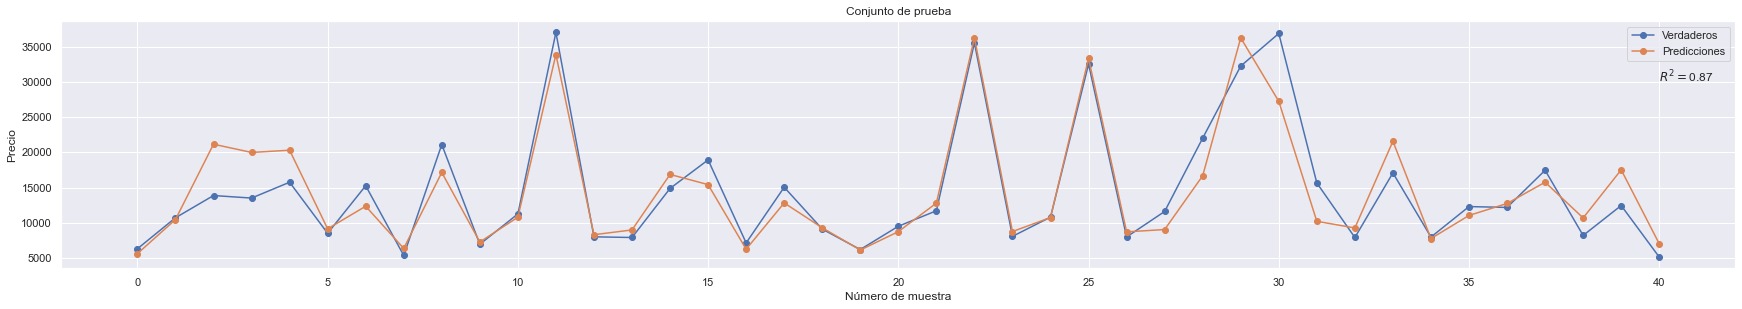

In [37]:
plt.figure(figsize=(30,10))
phi=poly.fit_transform(X_pru[:,np.array([0,1,2,4,6,7])])
plt.subplot(2,1,1)
plt.plot(y_pru,'-o')
y_pred=m.predict(phi)
plt.plot(y_pred,'-o')
plt.text(40,30000,'$R^2=${r2:.2f}'.format(r2=m.score(phi,y_pru)))
plt.title('Conjunto de prueba')
plt.xlabel('Número de muestra')
plt.ylabel('Precio')
plt.legend(['Verdaderos','Predicciones'])
plt.show()

## Comentarios y observaciones:

- En la primera parte (a) se tiene un modelo bastante complejo por el número de atributos que se considera, lo que provoca que el entrenamiento sea muy tardado, además que se sobreajusta inmediatamente desde la expansión polinomial de grado 2.
- En la segunda parte (b) con la penalización se reduce el sobreajuste considerablemente, sin embargo para la penalización con norma $l_2$  el error cuadrático medio es muy grande.
- En la última parte (c) se obtienen los errores cuadráticos más pequeños de todos los modelos, pues se realiza una selección de atributos (no exhaustiva), lo que también reduce la complejidad y el tiempo de procesamiento.
- Se recomienda normalizar o reescalar los datos de entrada para que todas las características contribuyan proporcionalmente a las distancias o errores, además que ayuda a tener los resultados en una escala más pequeña.